<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/RL/DZ_2/next_traiin_DDQ_time_lstm_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучение агента на среде [ViZDoom](https://github.com/mwydmuch/ViZDoom)

Сценарий - "защищай центр" (defend the center)

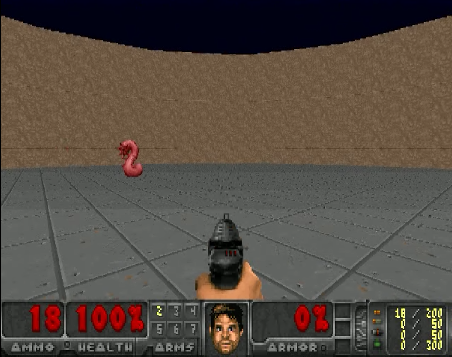

# Устанавливаем саму библиотеку ViZDoom из её гитхаб репозитории.

Для того, чтобы запустить среду ViZDoom в колаб-ноутбуке, нужно установить дополнительные программы, которые упомянаются в официальной [документации](https://vizdoom.farama.org/introduction/pythonQuickstart/).

Обычно уходит 3-5 минут на установку этой библиотеки.

In [1]:
%%bash
# %%bash - значит используем командную строку (не код питона)
apt-get update
# Устанавливаем нужные программы, которая требует от нас документация
apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Устанавливаем библиотеку Boost
apt-get install libboost-all-dev

# Устанавливаем зависимости Lua
apt-get install liblua5.1-dev

# установку самой библиотеки.
pip install vizdoom

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,641 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,067 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,081 kB]
Hit:13 https://ppa.launchpadconte

# Устанавливаем саму библиотеку ViZDoom из её гитхаб репозитории.

Для того, чтобы запустить среду ViZDoom в колаб-ноутбуке, нужно установить дополнительные программы, которые упомянаются в официальной [документации](https://vizdoom.farama.org/introduction/pythonQuickstart/).

Обычно уходит 3-5 минут на установку этой библиотеки.

## Cкачиваем нужный сценарий для среды ViZDoom.
Сценарий - "защищай центр" ([defend the center](https://vizdoom.farama.org/environments/default/))

**Брать файлы defend_the_center.cfg и defend_the_center.wad - можно отсюда**

https://github.com/Farama-Foundation/ViZDoom/blob/master/scenarios/defend_the_center.wad

In [2]:
import gdown
# Подгружаем с публичной папки по https
file_path = 'https://drive.google.com/file/d/18yFz4O3O1L8o4HZNDF899-fVdDHzOtcZ/view?usp=drive_link'
# находим ID
file_id = file_path.split('/')[-2]
gdown.download('https://drive.google.com/uc?id=' + file_id, "scenario.zip", quiet=False)
# Разархивируем файлы
!unzip -qo /content/scenario.zip -d /content/

Downloading...
From: https://drive.google.com/uc?id=18yFz4O3O1L8o4HZNDF899-fVdDHzOtcZ
To: /content/scenario.zip
100%|██████████| 3.11k/3.11k [00:00<00:00, 143kB/s]


# Скачиваем функции с репозитория

In [3]:
!git clone https://github.com/Mike030668/MIPT_magistratura.git -q
import sys
MAIN_DIR =  "/content/MIPT_magistratura/RL/DZ_2"
sys.path.append(MAIN_DIR)

from scripts.model import Make_DQN, update_target_model, train_network
from scripts.preprocessing import preprocess_frame
from scripts.rl_process import get_action, get_reward
from scripts.show_train import moving_average, show_scores
from scripts.memory import add_to_memory, sample_from_memory_m

# imports

In [14]:
# Импортируем все функции из cреды ViZDoom
from vizdoom import *

# Библиотека тензорфлоу
import tensorflow as tf

# Библиотека numpy
import numpy as np

# Импортируем модуль для генерации рандомных значений
import random

# Модуль для сохранения результатов в файл
import pickle

# Модуль для работы с картинками и видео (нужно для предобработки данных и записи результата)
import cv2

# Тип данных deque (список, где автоматический удаляются старые значения при добавлении новых, чтобы не переполнять память)
from collections import deque

# Модуль очистки
import gc

# Функция для удобного onehot энкодинга
from tensorflow.keras.utils import to_categorical

# Особенности реализации данного DDQN

- используется временная модель для анализа последовательного набора кадров. тут на 9 кадров
- для этого изменен алгоритм сбора последовательных кадров, с частотой которую задаюм. тут через 4 кадра
- от среды мы имеем ответ в виде:
    *   ammo остаток патрон;
    *   player’s health текущее здоровье;
    *   reward:
        *  +1 for killing a monster
        *  -1 for death
        *  0 nothing

- к базовому вознаграждению сделана функция get_reward, котрая доет добавки в зависимости сколько мы в игре, как изменилось здоровье (нас атакуют разные и урон разный), стреляли ли ...:
                # Если кадр является последним в игре, ставим награду как -0.1 и возвращаем её (агент умер)
                if episode_done:
                    reward = -0.5 * previous_info[3]/(current_info[3] + psi)
                    return reward

                # Если убили врага в кадре, увеличиваем награду на 1
                if current_info[0] > previous_info[0]:
                    reward += 1

                # Если потеряли здоровие, уменьшаем на соотношение разницы к прошлому
                if current_info[1] < previous_info[1]:
                    reward -= 0.3*(previous_info[1]-current_info[1])/(previous_info[1] + psi)

                # Если использовали патрон, уменьшаем награду на 0.1
                if current_info[2] < previous_info[2]:
                    reward -= 0.1

                # Если живы
                if current_info[3] > previous_info[3]:
                  reward += 0.1 * previous_info[3]/(current_info[3] + psi)

- мы може управлять - лево, право и стрелять. Всего 26 патрон и 100 очков здоровья. Нас атакую монстры с близи и стреляют пришельцы. Урон разный и это отражается в остатке здоровья.

- кроме базового стека памяти организован стек приоретизированой памяти, куда отбираются лучшие фрагменты выше порога, который смещается по мере обучения на основе общего результата игры от среды

- отбор в стек лучших кадров(тут у нас 9 для сети) идет на основе рейтинга, на сколько улучшилось состояни (в стандартного плюс кастомный выигрыш/проигрыш) во фрагменте посде прошлого фрагмента.

- после окончпния игры, собранный steck_episode с игры, тех фрагментов, что улучшали состоянию, могут быть добавлены в память лучших игр `best_games`. Порог сбора постепенно растет по мере повышения уровня игры агента.

- если рейтинг стека превысил текущий порог, то обновлем целевую в этот момент, внепланово.

- как в стандартном обновляем целевую модель весами основной модели раз в заданное количество target_model_update_frequency шагов, но перед этим еще тренеруем на лучших фрагментах `best_games`.

-----------------------------
**Задача состоит в том как научится стрелять максимально метко**

Текущее состояние сети уже может выдавать поажение 22 противников и способно учиться далее.
________________________________
Данная структура обучения, позволяла добиваться ранее работы агента на максимуме и без просадок

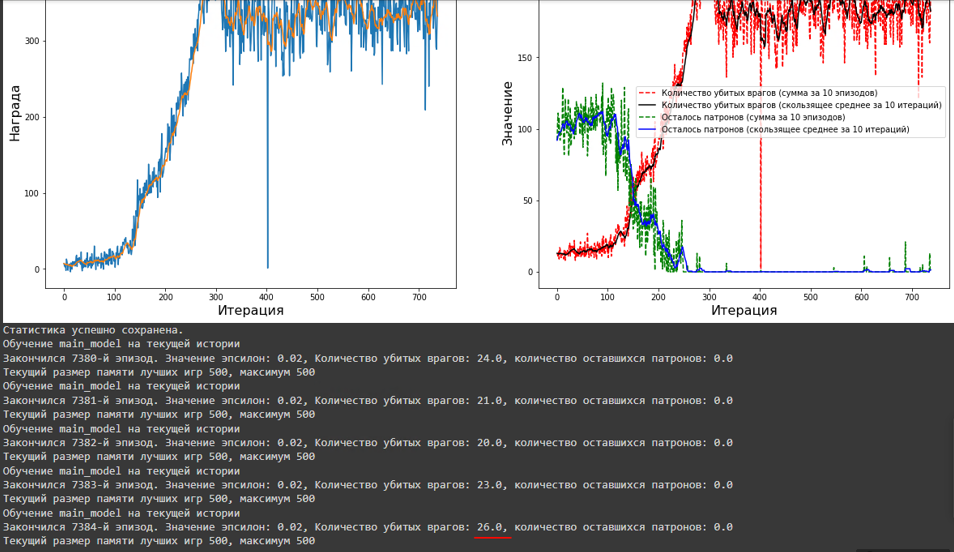

# Гиперпараметры
для обучения нашей DQN нейросети

Ниже задаются различные гиперпараметры для обучения нашей DQN нейросети. Более важные гиперпараметры подробнее описываются ниже:

- **gamma (гамма):** параметр для передачи наград между состояний. Значение от 0 до 1 - чем больше значения этого параметра, тем больше нейронная сеть будет приоритезировать награды которая она может получить в будующем.

- **observation_steps (количество шагов наблюдения):** количество шагов, за который алгоритм не обучается но добавляет новую информацию (состояния, действия, награды) в память. Это необходимо, чтобы алгоритм не переобучался на маленьком объеме памяти.

- **target_model_update_frequency (частота обновления целевой модели):** Определяет количество шагов, после которого мы обновляем целевую модель (копируем все веса основной модели в целевую модель). В оригинальной статье по Q-learning использовалось 10000 шагов, но в этом примере мы будем использовать 5000 шагов.

In [5]:
gamma = 0.95                           # Гамма
observation_steps = 10000              # Количество шагов
target_model_update_frequency = 15000  # Частота обновления целевой


initial_epsilon = 0.6            # Начальное значение эпсилон (вероятность принять рандомный шаг)
epsilon = initial_epsilon        # Текущее значение эпсилон (инициализируется как стартовое значение)
final_epsilon = 0.01             # Минимальное значение эпсилон (должен быть выше 0)
epsilon_decay_steps = 250000     # Мы будем уменьшать значение эпсилона на протяжении 200,000 шагов
epsilon_decay_factor = 0.99999    #Задаем число, на которое будем умножать эпсилон после каждого шага

timesteps_per_train = 150       # Обучаем модель раз в 100 шагов (не обязательно ждать до конца игры)
learning_rate = 1e-4            # Обычно в обучении с подкреплением ставят низкий шаг обучения, например 1e-4
batch_size = 3                 # Используем размер пакета в 32



# Другие гиперпараметры
image_width = 64   # Ширина картинки (кадра)
image_height = 64  # Высота картинки (кадра)
chanels = 3
num_frames = 9     # Количество последовательных кадров в одном состоянии (используется позже)
action_size = 3


# Размерность каждого состояния - размер картинки
state_shape = (num_frames, image_width, image_height, chanels)

# Установим количество кадров за каждое действие. Нам не нужен каждый кадр,
# по этому будем совершать действие и брать новое состояние лишь раз в 3 кадра.
frames_per_action = 4




## Создаем буферы памяти.
В ходе обучения, мы будем сэмплить примеры из буфера рандомным образом чтобы избежать переобучение.

Для создания буфера мы будем использовать специальный тип данных из встроенного модуля питона, который называется deque. Deque работает также как обычный питоновский список, но с одном важным отличием - у него есть максимальная длина (максимальное количество элементов, которое может храниться одновременно).

Когда эта максимальная длина привышается и в deque добавляется новый элемент, также будет удаляться самый старый элемент. В итоге, у нас будет буфер памяти который хранит данные за большое количество игр, но очень старые данные на которых уже несколько раз происходило обучение и которые больше не актуальные будут удаляться автоматический. Всё это заложенно внутри самого объекта deque, и по этому им очень удобно пользоваться для подобных задач.



In [6]:
# В памяти будет храниться не более 2500 пар текущих и следующих состояний,
# действия которые нейронная сеть выбрала, а также их соответствующие награды.
maximum_memory_length = 2500
# Создаем буфер памяти
base_memory = deque([], maxlen = maximum_memory_length)
memory_exist = False
min_memory = 300

# В памяти будет храниться не более 250 пар текущих и следующих состояний,
# действия которые нейронная сеть выбрала, а также их соответствующие награды.
# В ЛУЧШИХ ИГРАХ
maximum_best_games_length = 250
# Создаем буфер памяти
best_games = deque([], maxlen = maximum_best_games_length)
memory_b_exist = False

# Создание игровой среды, инициализация нейронной сети

В данном уроке мы будем обучать бота играть в сценарий, который называется "защищай центр" (defend the center). Игрок находиться в центре большой, круглой комнате, где появляются различные враги.

У игрока есть пистолет, 26 патронов, и он может совершать три действия (повернуть влево, повернить вправо, выстрелить). Игра заканчивается когда игрока убивают монстры, что по любому произойдёт рано или поздно (патроны закончаться, игрок не может убегать, по этому его убьют). Цель игрока - убить максимальное количество монстров до того, как закончаться патроны. В идеале игрок сможет убить 26 монстров.



In [8]:
# Инициализируем среду
game = DoomGame()

# Загружаем сценарий
game.load_config("/content/scenario/defend_the_center.cfg")

# Устанавливаем размер кадров среды (будет 640 х 480)
game.set_screen_resolution(ScreenResolution.RES_640X480)

# Нужно отключить окно чтобы не было ошибки
game.set_window_visible(False)

# Инициализируем игру
game.init()

# Извлекаем количество возможных уникальных действий
action_size = game.get_available_buttons_size()

# Создаем основную модель (будет обучаться)
main_model = Make_DQN(state_shape, action_size, learning_rate)

# Создаем целевую сеть (не будет обучаться, переодический будет обновляться под основную модель)
target_model = Make_DQN(state_shape, action_size, learning_rate)

# Устанавливаем параметры целевой модели (копируем в неё значения основной модели)
update_target_model(target_model, main_model)



# Обученная модель и ее история

In [9]:
# Подгружаем с публичной папки по https
file_path = 'https://drive.google.com/file/d/1KeOElI7ROFvnIUFoXkWatscPoqPvHVrN/view?usp=sharing'
# находим ID
file_id = file_path.split('/')[-2]

model_name = 'vizdoom_DQN_model.h5'
gdown.download('https://drive.google.com/uc?id=' + file_id, model_name, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1KeOElI7ROFvnIUFoXkWatscPoqPvHVrN
To: /content/vizdoom_DQN_model.h5
100%|██████████| 1.98M/1.98M [00:00<00:00, 129MB/s]


'vizdoom_DQN_model.h5'

In [10]:
# Подгружаем с публичной папки по https
file_path = 'https://drive.google.com/file/d/1VLEpcwYk60IWQF0tXbkaU0AfOi1Es5lp/view?usp=sharing'
# находим ID
file_id = file_path.split('/')[-2]

file_name = 'vizdoom_DQN_stats.txt'
gdown.download('https://drive.google.com/uc?id=' + file_id, file_name, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1VLEpcwYk60IWQF0tXbkaU0AfOi1Es5lp
To: /content/vizdoom_DQN_stats.txt
100%|██████████| 19.7k/19.7k [00:00<00:00, 33.7MB/s]


'vizdoom_DQN_stats.txt'

In [11]:
# Решаем, если мы обучаем можель с нуля или продолжаем предидущую сессию обучение.
load_pretrained = True
load_statistic = True

SAVE_PATH = "/content" # куда писать далее
#Если хотим продолжить текущее обучение, загружаем сохраненные веса для основной и целевой модели
if load_pretrained:
  main_model.load_weights("/content/vizdoom_DQN_model.h5")
  target_model.load_weights('/content/vizdoom_DQN_model.h5') #
  model_weights = True

  if load_statistic:
      # Также загружаем ранее сохраненные статистики из pickle файла.
      with open('/content/vizdoom_DQN_stats.txt', 'rb') as f:
        record_rewards, record_kills, record_ammos, episode_number, timestep, epsilon, best_episod = pickle.load(f)
  else:
    record_rewards = []          # Сюда будем записывать награды за 10 эпизодов (для анализа статистики)
    record_kills = []            # Сюда будем записывать количество убитых врагов (для анализа статистики)
    record_ammos = []            # Сюда будем записывать количество оставшихся патронов (для анализа стаистики)
    episode_number = 1     # Инициализицем номер эпизода как 1
    timestep = 0           # Инициализируем номер шага как 0
    model_weights = True
    best_episod = 0


# Иначе мы просто инизиализируем списки, в которых будет храниться статистика о работе агента.
else:
  record_rewards = []          # Сюда будем записывать награды за 10 эпизодов (для анализа статистики)
  record_kills = []            # Сюда будем записывать количество убитых врагов (для анализа статистики)
  record_ammos = []            # Сюда будем записывать количество оставшихся патронов (для анализа статистики)

  episode_number = 1     # Инициализицем номер эпизода как 1
  timestep = 0           # Инициализируем номер шага как 0
  model_weights = True
  best_episod = 0

# Создние игрового цикла

В нем агент будет играть в игру и обучаться.

Данная игра и алгоритм относительно простые, и в итоге обучается примерно 10 часов на процесорре в колабе (результаты видны после ~5 часов). Другие алгоритмы, или даже тот же алгоритм в более сложной среде может обучаться намного дольше.

## Инициализируем переменные и проведем предобработку:

In [12]:
from copy import deepcopy
# Генерим новый эпизод
game.new_episode()

# Извлекаем первый кадр (это ещё не полноценное состояние)
game_data = game.get_state()

# Инициализируем сборщик истории
current_info =  np.zeros(4)

# Записываем информацию о текущем моменте как 'предыдущий' момент (чтобы потом могли сравнить разницу)
previous_info = deepcopy(current_info)

# Извлекаем кадр из игры (480 x 640)
frame = game_data.screen_buffer
# Предобрабатываем кадр в чёрно-белый (размер 64 х 64)
processed_frame = preprocess_frame(frame,
                                  image_width,
                                  image_height,
                                  chanels)
processed_frame = np.reshape(processed_frame, (1, 64, 64, chanels))

# В качестве первого состояния, просто дублируем кадр 4 раза.
current_state = np.vstack([processed_frame for i in range(num_frames)])
# Инициализируем предыдущий шаг как текущий шаг
previous_state = deepcopy(current_state)

reward_frame = np.zeros(num_frames)
last_reward_frame = reward_frame

# Инициализируем награды
interval_reward = 0  # за интервал (10 эпизодов) как 0
interval_kills = 0   # за количество убитых врагов (10 эпизодов) как 0
interval_ammos = 0   # за количество оставшихся патронов (10 эпизодов) как 0

# стартоые состояния стека
steck_episode = []
episod_reward = 0
new_episod = False
avr_wind = 10
game_step = 0

## Обучение:

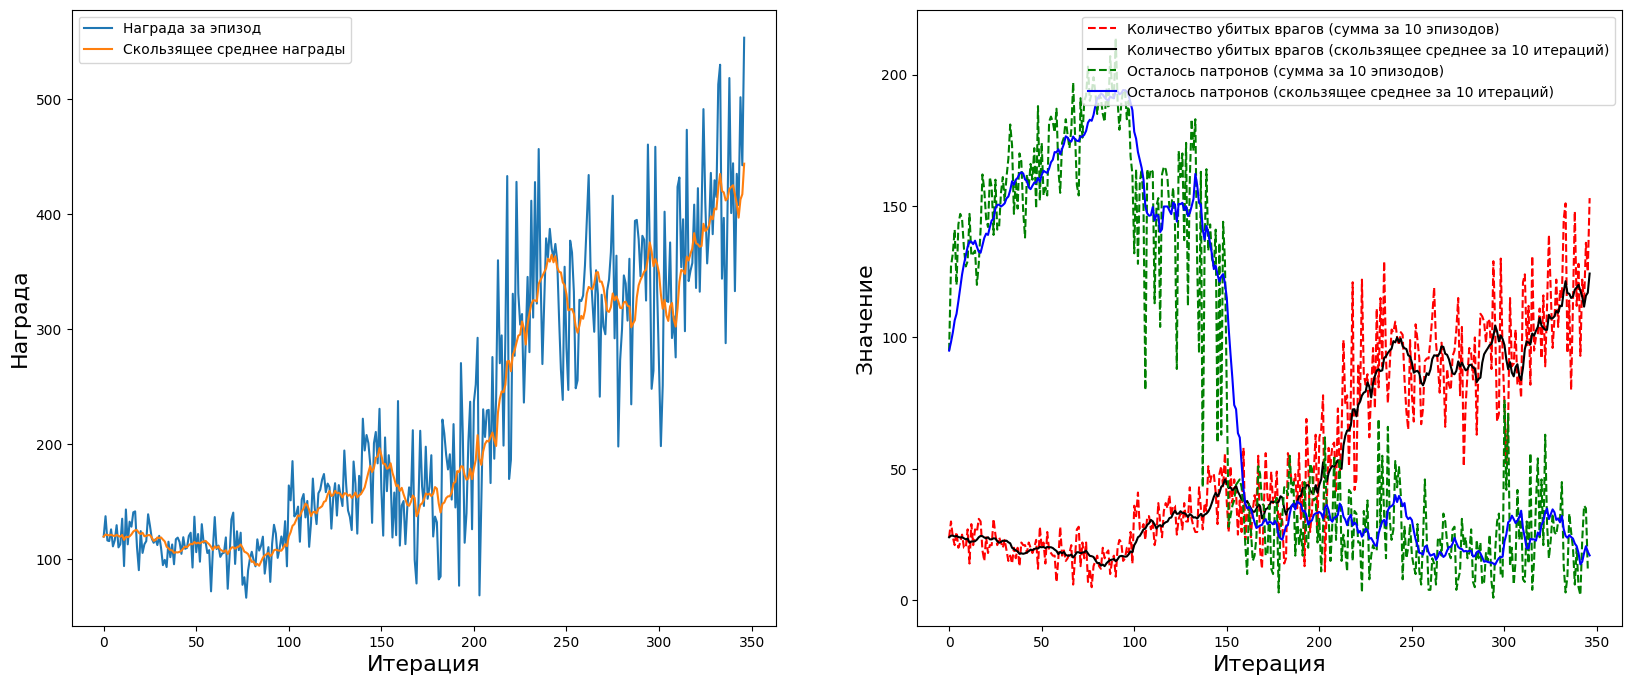

Статистика успешно сохранена.
1/1 [==============================] - 0s 41ms/step
Обучение main_model на текущей истории
1/1 [==============================] - 0s 45ms/step
Закончился 3470-й эпизод. Значение эпсилон: 0.01, Количество убитых врагов: 7.0, количество оставшихся патронов: 4.0
1/1 [==============================] - 0s 40ms/step
Обучение main_model на текущей истории
1/1 [==============================] - 0s 47ms/step
Обучение main_model на текущей истории
1/1 [==============================] - 0s 39ms/step
Закончился 3471-й эпизод. Значение эпсилон: 0.01, Количество убитых врагов: 21.0, количество оставшихся патронов: 0.0
Текущий размер памяти лучших игр 250, максимум 250
1/1 [==============================] - 0s 65ms/step
Обучение main_model на текущей истории
1/1 [==============================] - 0s 62ms/step
Обучение main_model на текущей истории
1/1 [==============================] - 0s 40ms/step
Закончился 3472-й эпизод. Значение эпсилон: 0.01, Количество убитых враго

In [ ]:
while episode_number < observation_steps:
    # Увеличиваем номер шага на 1
    timestep += 1
    # Извлекаем индекс награды и новое значение эпсилон
    action_index, epsilon, type_act = get_action(main_model,
                                                 previous_state,
                                                 action_size,
                                                 epsilon,
                                                 final_epsilon,
                                                 epsilon_decay_factor
                                                 )

    # Приводим награду в onehot массив
    action_onehot = to_categorical(action_index)
    # Подаем действие в игровую среду в качестве списка
    game.set_action(action_onehot.tolist())
    # Игра продвигается на 4 кадра (значение frames_per_action)
    game.advance_action(frames_per_action)
    current_info[3] += frames_per_action

    # Предобрабатываем кадр в (размер 64 х 64 x 1)
    game_data = game.get_state()

    # Проверяем если эпизод закончился
    episode_done = game.is_episode_finished()

    # Нам необходимо возобновить среду и записать нужные статистики когда заканчивается эпизод
    if episode_done:
        interval_kills += current_info[0]      # убили монстров
        interval_ammos += current_info[2]      # патроны

        information = f"Закончился {episode_number}-й эпизод. Значение эпсилон: {round(epsilon, 2)}, "
        information += f"Количество убитых врагов: { current_info[0]+1}, "
        information += f"количество оставшихся патронов: {current_info[2]}"
        print(information)

        episode_number += 1   # Увеличиваем номер эпизода на 1

        ##############################################################################
        ##                  Блок сбора данны best_games                             ##
        ##############################################################################
        # Собираем в пмять лучших выше определенного уровня от лучшей игры
        if episod_reward > best_episod//2:
            # добавляем стек в память лучших игр
            best_games.extend(steck_episode)
            memory_b_exist = True
            k = len(best_games)-1
            print(f'Текущий размер памяти лучших игр {k+1}, максимум {maximum_best_games_length}')
            # сортируем для сожранения лучших и выбытию хдших
            if memory_b_exist and len(list(best_games)) > min_memory:
                best_games = deque(sorted(list(best_games),
                                          key = lambda k : k[5]),
                                          maxlen = maximum_best_games_length)

            # переназначение и сохранение лучшего результата и модели
            if episod_reward > best_episod:
                best_episod = episod_reward
                # Сохраняем веса модели
                print(f'Сохраняем веса модели c best_episod = {episod_reward}')
                main_model.save_weights(SAVE_PATH + '/vizdoom_DQN_model.h5')
                model_weights = True
        # сброс для нового эпизода
        steck_episode = []
        episod_reward = 0
        current_info =  np.zeros(4)
        previous_info = deepcopy(current_info)
        ##############################################################################

        # Чтобы не собирать слишком много данных и чтобы данные было удобно отображать на графике
        # Записываем результат раз в avr_wind = 10 эпизодов
        if episode_number % avr_wind == 0 and episode_number > 0:
            # Добавляем награду в список всех наград
            record_rewards.append(interval_reward)
            # Добавляем количество убитых врагов
            record_kills.append(interval_kills)
            # Добавляем количество неиспользованых патронов
            record_ammos.append(interval_ammos)
            # Записываем результаты в графики
            show_scores(record_rewards, record_kills, record_ammos, window = avr_wind)

            # Записываем статистику в файл через библиотеку pickle
            with open(SAVE_PATH+'/vizdoom_DQN_stats.txt', 'wb') as f:
              pickle.dump([record_rewards, record_kills, record_ammos, episode_number,
                          timestep, epsilon, best_episod], f)
            print("Статистика успешно сохранена.")

            # Заново инициализируем значения статистики для интервала в avr_wind = 10 эпизодов
            interval_reward, interval_kills, interval_ammos = 0, 0, 0


        # Начинаем новый эпизод игры
        game.new_episode()
        # Извлекаем новое состояние игры
        game_data = game.get_state()
        new_episod = True

    # Извлекаем информацию о игровой среде (количество убитых врагов, неиспользованных патронов, текущее здоровие)
    game_info = game_data.game_variables
    current_info[1] = game_info[1] # здоровье
    current_info[2] = game_info[0] # патроны


    # Извлекаем новый кадр из игры
    frame = game_data.screen_buffer
    # Предобрабатываем кадр (новая размерность будет 64 х 64 х chanels)
    processed_frame = preprocess_frame(frame,
                                       image_width,
                                       image_height,
                                       chanels)
    processed_frame = np.reshape(processed_frame, (1,64,64, chanels))

    if new_episod:
        current_state =  np.vstack([processed_frame for i in range(num_frames)])
        previous_state = deepcopy(current_state)
        new_episod = False
    else:
        # Обновляем состояние - удаляем последний кадр и добавляем новый
        current_state = np.append(current_state[1:num_frames, :, :, :], processed_frame,  axis = 0)

    # Извлекаем награду за шаг из среды (логика, которую не можем менять)
    environment_reward = game.get_last_reward() # (+1; 0; -1)
    #print("environment_reward", environment_reward)
    if environment_reward == 1: #
       current_info[0] += environment_reward # награда, можно воспринимать как к-во убитых
    else:
       # если живы, то не изменится (т.к 0), а убиты, то уменьшиться (т.к -1)
       current_info[3] += game_step * environment_reward

    # Извлекаем награду за шаг из самописный функции (самописная награда, значит можем менять логику)
    custom_reward = get_reward(previous_info, current_info, episode_done)

    # Общая награда - это сумма награды из среды и самописной награды
    reward = environment_reward + custom_reward

    # Добавляем предыдущее состояние, действие, награду, и текущее состояние в память
    base_memory = add_to_memory(base_memory, previous_state, action_index,
                                reward, current_state, episode_done)
    # Добавляем награду в переменную для статистики
    interval_reward += reward

    ##############################################################################
    ##                     Блок отбора стека эпизода                            ##
    ##############################################################################
    # учет в вознагрждении действия сети или случая, снижается со снижением epsilon
    if type_act: k = 0.9 + epsilon
    else: k = 1
    reward_k = environment_reward + custom_reward*k

    # текущий рейтинг эпизода
    episod_reward += reward_k

    # рейтинг фрейма
    reward_frame = np.append(reward_frame[1:], [reward_k],  axis = 0)
    sum_frame = np.sum(reward_frame)

    # отбираем действи увеличивающиеся вознаградения от кадра к кадру
    if  sum_frame > np.sum(last_reward_frame):
        # собираем стек эпизода
        steck_episode.append([previous_state, action_index,
                              reward, current_state, episode_done, sum_frame])

    last_reward_frame = reward_frame
    ##############################################################################

    # Обучаем нашу модель раз в 100 шагов, но только если у нас достаточно данных в памяти
    if timestep % timesteps_per_train == 0:
        print(f'Обучение main_model на текущей истории')
        train_network(
                      main_model,
                      target_model,
                      batch_size,
                      gamma,
                      timesteps_per_train,
                      num_frames,
                      image_width,
                      image_height,
                      chanels,
                      memory = base_memory,
                      part_memory = True
                      )
        gc.collect()

    # Обновляем целевую модель весами основной модели раз в заданное количество target_model_update_frequency шагов
    if timestep % target_model_update_frequency == 0:
        if len(best_games) > maximum_best_games_length//5:
            print(f'Обучение main_model на лучших')
            train_network(
                          main_model,
                          target_model,
                          batch_size,
                          gamma,
                          timesteps_per_train,
                          num_frames,
                          image_width,
                          image_height,
                          chanels,
                          memory = best_games,
                          part_memory = False,
                          )
        print(f'Обновление весов target_model')
        target_model.load_weights(SAVE_PATH+'/vizdoom_DQN_model.h5')
        gc.collect()

    # Запоминаем предыдущию информацию
    previous_info = deepcopy(current_info)
    # Запоминаем предыдущее состояние
    previous_state = deepcopy(current_state)
    gc.collect()

